## Linear Regression with TensorFlow

The first approach is closed form exact solution based on the Normal Equation. The second appoach uses the Maximium Likelihood Estimation (MLE). THe third one uses Stochaistic Gradient Descent with Mini-Batches

In [4]:
import os
import numpy as np
import math as m

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D 

import pandas as pd
import tensorflow as tf

In [5]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


### Linear Regression

$ y(x) = a + b_1 \cdot X_1 + b_2 \cdot X_2 + b_3 \cdot X_3 + \sigma \cdot \varepsilon $ 

where $ \varepsilon \sim N(0, 1) $ is a Gaussian noise, and $ \sigma $ is its volatility, 
with the following choice of parameters:

$ a = 1.0 $

$ b_1, b_2, b_3 = (0.5, 0.2, 0.1) $

$ \sigma = 0.1 $

$ X_1, X_2, X_3 $ will be uniformally distributed in $ [-1,1] $

## Generate data

In [11]:
n_points = 5000
n_features = 3

bias = np.ones(n_points).reshape((-1,1))
low = -np.ones((n_points, n_features), 'float')
high = np.ones((n_points, n_features), 'float')

#simulated features
X = np.random.uniform(low=low, high=high)

#simulated noise
noise = np.random.normal(size=(n_points, 1))

#outputs
weights = np.array([1.0, 0.5, 0.2, 0.1])
noise_std = 0.1
Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1, 1))+noise_std * noise

#split to the train and test set
train_test_split = 4 #1/4 of the data is used for test
n_test = int(n_points/train_test_split)
n_train = n_points - n_test

X_train = X[:n_train, :]
Y_train = Y[:n_train].reshape((-1, 1))

X_test = X[n_train:, :]
Y_test = Y[n_train:].reshape((-1, 1))

In [12]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3750, 3), (3750, 1), (1250, 3), (1250, 1))

## Linear Regression with Numpy

In [13]:
#we define an augmented data matrix by adding a column of ones at the
# left
X = np.hstack((np.ones(n_train).reshape((-1, 1)), X_train))

#then we apply the normal equation
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y_train)

print(theta_numpy)

[[0.99742063]
 [0.49754629]
 [0.19934369]
 [0.09850036]]


## Linear Regression with Sklearn 

In [15]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[0.99742063]
 [0.49754629]
 [0.19934369]
 [0.09850036]]


## Linear Regression with Tensorflow

In [16]:
#here we make an augmented data matrix that we will call X_np
# add the column of ones to np a
X_np = np.hstack((np.ones(n_train).reshape((-1, 1)), X_train))

#we create two tensorflow nodes
#which we initialize to X_np and Y_train
X = tf.constant(X_np, dtype=tf.float32, name="X")
y = tf.constant(Y_train, dtype=tf.float32, name="y")
XT = tf.transpose(X)

#then we implement the normal equation
#this time using tensoflow matrix operations
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

#Then we announce our session to compute the values of theta
with tf.Session() as sess:
    theta_value = theta.eval()

In [17]:
theta_value

array([[0.99742055],
       [0.4975462 ],
       [0.19934364],
       [0.09850033]], dtype=float32)

## A simple class for Linear Regression
Implements the Normal Equation and MLE(Maximum Likelihood estimation) solutions

In [50]:
class Model:
    def __init__(self, n_features, learning_rate=0.05, L=0):
        #input placeholders 
        # --> Placeholders are special nodes in the tensorflow graph that do not do any computation but simply
        #pass the input data at runtime
        #Tensorflow needs to know what type of tensor it should create for these data:
        # The first argument will be the type(ie, float32)
        # The second argument will be the shape of a tensor [rows, columns]
        # In the first we see the number of points can be anything (represented by None)
        #However the number of columns is represented by the number of features
        self.X = tf.placeholder(tf.float32, [None, n_features], name="X")
        self.Y = tf.placeholder(tf.float32, [None, 1], name="Y")

        #regression parameters for the analytical solution using the Normal equation
        self.theta_in = tf.placeholder(tf.float32, [n_features+1, None])
        
        #Augmented data matrix is obtained by adding a column of ones to the data matrix
        data_plus_bias = tf.concat([tf.ones([tf.shape(self.X)[0], 1]), self.X], axis=1)
        
        XT = tf.transpose(data_plus_bias)
        
        ##############
        #The normal equation for Linear Regression
        
        self.theta = tf.matmul(tf.matmul(
            tf.matrix_inverse(tf.matmul(XT, data_plus_bias)), XT), self.Y)
        
        #mean square error in terms of theta = theta_in
        self.lr_mse = tf.reduce_mean(tf.square(
            tf.matmul(data_plus_bias, self.theta)-self.Y))
        
        ###############
        #Estimate the model using the Maximum Likelihood Estimation(MLE)
        
        #Regression parameters for the MLE method
        #Note that there are n_features+2 parameters, as one is added for the intercept,
        #an another one fot he std of noise
        
        #self.weights will store the result of our MLE estimation
        self.weights = tf.Variable(tf.random_normal([n_features+2, 1]))
        
        #prediction from the model
        self.output = tf.matmul(data_plus_bias, self.weights[:-1, :])
        
        #The next lines compute the negative log likelihoods for linear regression
        gauss = tf.distributions.Normal(loc=0.0, scale=1.0)
        
        #Standard Deviation of the Gaussian noise is modelled as a square of the last model_weight
        #Trick by setting the std of volatility sigma as a square of the last weight plus some small positive number
        #This is made to ensure that the log likelihood defined here stays well defined for all values of weights
        sigma = 0.0001 + tf.square(self.weights[-1])
        
        #pi = tf.constant(m.pi)
        
        log_LL = tf.log(0.00001 + (1/sigma) * gauss.prob((self.Y - self.output) / sigma))
        
        #Loss is the negative log-likelihood
        self.loss = -tf.reduce_mean(log_LL)
        
        #TF node defining an Op for on training set
        # --> defines a node that specifies an optimization method that will be performed iterably
        # --> We use AdamOptimizer but tf has many more like gradient descent optimizer
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), self.loss)
        
        #The rest of the class is a function that generates the synthetic data
        
    def generate_data(n_points = 10000,
                      n_features = 3,
                      weights = np.array([1.0, 0.5, 0.2, .1]),
                      noise_std = 0.1):
            
        bias = np.ones(n_points).reshape((-1, 1))
        low = -np.ones((n_points, n_features), 'float')
        high = np.ones((n_points, n_features), 'float')
            
            #simulated features
        X = np.random.uniform(low=low, high=high)
            
            #simulated noise
        noise = np.random.normal(size=(n_points, 1))
            
            #outputs
        Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1, 1)) + noise_std * noise
            #print('Shapes in generate data: ', X.shape, weights.shape, noise.shape, Y.shape)
            
        return (X, Y)
        
def main():
    #The main function creates the data first
    n_points = 5000
    n_features = 3
    learning_rate = 0.05
    
    # n_features + 1 weights(one for a constant feature)
    weights = np.array([1.0, 0.5, 0.2, 1])
    noise_std = 0.1
    
    #Make data
    (X, Y) = Model.generate_data(n_points=n_points,
                                n_features=n_features,
                                weights=weights,
                                noise_std=noise_std)
    ###########
    #Then we create the train and test data sets
    
    #split to the train and test set
    train_test_split = 4 #1/4 of the data is used for a test
    
    n_test = int(n_points/4)
    n_train = n_points - n_test
    
    X_train = X[:n_train, :]
    Y_train = Y[:n_train].reshape((-1, 1))
    
    X_test = X[n_train:, :]
    Y_test = Y[n_train:].reshape((-1, 1))
    
    #create an instance of the Linear Regression model class
    model = Model(n_features=n_features, learning_rate=learning_rate)
    
    #train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
    #How we run the graph
    #to compute the nodes defined in our class we need to fill the placeholders that we created
    #This is done at runtime using a dictionary called feed_dict whose keys are the placeholder's nodes and the values are the
    #model inputs
    #Calculation is done to comute both their optimal values of parameter and the train and test errors
        theta_value = sess.run(model.theta, feed_dict={model.X: X_train, model.Y: Y_train})
    
    #Note that in these last two calculation we compute the same node but filled their placeholders differently each time
    #with different data
        lr_mse_train = sess.run(model.lr_mse, feed_dict={
            model.X: X_train,
            model.Y: Y_train,
            model.theta_in: theta_value
        })
    
        lr_mse_test = sess.run(model.lr_mse, feed_dict={
            model.X: X_test,
            model.Y: Y_test,
            model.theta_in: theta_value
        })
    
        print("===== Linear Rehression with the Normal Equation =====")
        print(theta_value)
        print("Linear regression train error:", lr_mse_train)
        print("Linear regression test error:", lr_mse_test)

        #Now train the MLE parameters
        #we are running 1000 steps of optimization that will keep updating model weights according to the minimisation scheme
        for i in range(0, 1000):
            #The code returns both the current value of the loss and the updated model weight
            (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                model.X: X_train,
                model.Y: Y_train
            })
        #After training is done above we want to test the model
        #Make test prediction
        Y_test_predicted = sess.run(model.output, feed_dict={
            model.X: X_test
        })

        #we compute the model predictions for the noise volatility
        #output std sigma is a square of the last weight
        std_model = weights[-1]**2
        print("====== Linear Regression with MLE =======")
        print("Negative Log-Likelihood:", loss)
        print("MLE fitted parameters:")
        print(weights[0:-1])
        print('Fitted std of noise: ', std_model)
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
        ax.scatter(X_test[:,1], X_test[:,2], Y_test_predicted, s=1, c="#FF0000")
        plt.show()
        sess.close()
    
        

===== Linear Rehression with the Normal Equation =====
[[1.0024506 ]
 [0.49675477]
 [0.19762994]
 [0.9989106 ]]
Linear regression train error: 0.009901529
Linear regression test error: 0.009873825
====== Linear Regression with MLE =======
Negative Log-Likelihood: -0.88860565
MLE fitted parameters:
[[1.0024489 ]
 [0.49675417]
 [0.19763012]
 [0.9988978 ]]
Fitted std of noise:  [0.0994022]


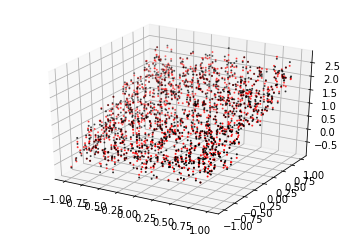

In [51]:
if __name__ == "__main__":
    main()